# What films are available to stream?
## Initialize

In [1]:
from bmb.source.standard_import import *
from bmb                        import IngestionDB
from bmb.source.webscraping     import films_available_to_stream
from matplotlib                 import pyplot as plt
ingestion = IngestionDB()

## Webscraping Films Available to Stream

All data acquisition is handled by the function `films_available_to_stream`, which uses Selenium to traverse the infinte scroll at [Justwatch](https://www.justwatch.com/us/movies).  The source for this function is not provided (none of my webscraping code is available to the public).

In [2]:
Webscrape = namedtuple( "Webscrape", "streamer ymin ymax")

scrapes   = (
    Webscrape( "Netflix", 1900, 1999),
    Webscrape( "Amazon" , 1900, 1999),
    Webscrape( "Hulu"   , 1900, 1999),
)

available_film_urls = {
    scrape : films_available_to_stream( 
        ingestion.Streamer_key( scrape.streamer),
        ymin=scrape.ymin  , 
        ymax=scrape.ymax  )
    for scrape in scrapes }

## Ingesting Results

This code is divided into two blocks.  This first block holds constants, SQL queries, and a helper function; the second block actually loads the webscraping result.

In [3]:
FILM_TABLE  = "JustwatchFilm"
STATE_TABLE = "JustwatchState"

OBSOLETE_STATES = f"""
SELECT 
    streamer,
    film 
FROM 
    {STATE_TABLE} sta 
    JOIN {FILM_TABLE} f ON sta.film = f.id
WHERE 
    streamer=? 
    AND f.year >= ? 
    AND f.year <= ? 
    AND sta.confirmed !=? 
    AND removed IS NULL
"""
REMOVE_STATE = f"UPDATE  {STATE_TABLE} SET removed=? WHERE streamer=? AND film=? AND removed IS NULL"

def summary( scrape, urls, not_seen_before, already_ingested, obsolete):
    summary = list()
    summary.append( f"{len(urls)} movies are available on {scrape.streamer} from {scrape.ymin}-{scrape.ymax}")
    summary.append( f"{len(not_seen_before) } are newly stream-able")
    summary.append( f"{len(already_ingested)} were previously located on a streaming service")
    summary.append( f"{len(obsolete)} films are no longer streamable and were marked as inactive")
    return "\n".join( summary )

In [4]:
summaries = list()
for scrape, urls in available_film_urls.items():
    
    #  Initialize variables.
    streamer_id      = ingestion.id( "Streamer", scrape.streamer)
    date_str         = ingestion.date_str
    already_ingested = *( url for url in urls if     ingestion.id( FILM_TABLE, url) ),
    not_seen_before  = *( url for url in urls if not ingestion.id( FILM_TABLE, url) ),
    
    # Confirm active streams.
    for url in urls:
        ingestion.confirm_active_stream( streamer_id, ingestion.JustwatchFilm( url), date_str)
    
    # If any films are no longer listed for streaming; remove them as obsolete. 
    obsolete = ingestion.get( OBSOLETE_STATES, streamer_id, scrape.ymin, scrape.ymax, date_str)
    for streamer, film in obsolete:
        ingestion.set( REMOVE_STATE, date_str, streamer, film)
    
    # Prepare human-readable summary.
    summaries.append( summary( scrape, urls, not_seen_before, already_ingested, obsolete))
    
print( "\n\n".join( summaries))

213 movies are available on Netflix from 1900-1999
0 are newly stream-able
213 were previously located on a streaming service
1 films are no longer streamable and were marked as inactive

1551 movies are available on Amazon from 1900-1999
4 are newly stream-able
1547 were previously located on a streaming service
0 films are no longer streamable and were marked as inactive

148 movies are available on Hulu from 1900-1999
0 are newly stream-able
148 were previously located on a streaming service
0 films are no longer streamable and were marked as inactive


## Identifying Films

At this point, the Ingestion Database is only aware of the URL for each streamable work, so to assign each an identity the `IngestionDB.identify_all_JustwatchFilm_URLs` method uses BeatifulSoup to find the title and release year of each film.  This is all the information ever collected on them by the Ingestion Database; it does not even verify that the title-year combinations it ingests represent actual films.

In [5]:
def print_unknown_url_count():
    QUERY = f"SELECT url FROM {FILM_TABLE} WHERE title IS Null;"
    print( f"{len(ingestion.get( QUERY))} Justwatch URL(s) in the database are unexplored.")
    
print_unknown_url_count()
ingestion.identify_all_JustwatchFilm_URLs(VERBOSE='jupyter')
print_unknown_url_count()

4 Justwatch URL(s) in the database are unexplored.


  0%|          | 0/4 [00:00<?, ?it/s]

0 Justwatch URL(s) in the database are unexplored.


**The codeblock above will usually show zero unexplored URLs.**  Here is an example of the output when there is data to find:

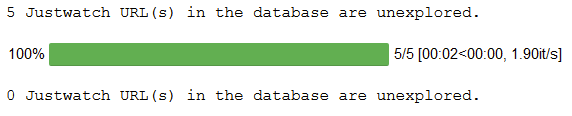

## Pie Chart: Where are movies available to stream?

**Disclaimer:** The values used for the visualization represent only the subset of streamable films that I have come across so far.  _This is not meant to be a serious analysis or comparison of the different streaming providers._

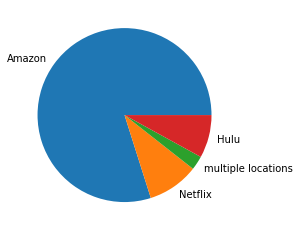

In [6]:
pie_values = defaultdict( lambda: 0)
films = ingestion.select( "id", "JustwatchFilm")

for film_id in films:
    QUERY = "SELECT s.name FROM JustwatchState jw JOIN Streamer s ON jw.streamer = s.id WHERE jw.film=?"
    locations = ingestion.get( QUERY, film_id)
    
    if len( locations) > 1:
        key = "multiple locations"
    elif len( locations) == 1:
        key = locations[0]
    elif not locations:
        key = "not available"
    pie_values[ key] += 1
    
labels, values = list(), list()
for l, v in pie_values.items():
    labels.append( l)
    values.append( v)
    
plt.pie( values, labels=labels)
plt.show()

## Transferring Films to the Processing Database

In [7]:
from bmb import ProcessingDB

processing = ProcessingDB()

streamable_films = ingestion.select( 'title', 'year', "JustwatchFilm")
    
for title, year in streamable_films:
    processing.Film( title, year)
    
for film_id in jupyter_aware_tqdm( processing.unverified_films,  VERBOSE='jupyter'):
    processing.lookup_film_info( film_id)

  0%|          | 0/4 [00:00<?, ?it/s]